In [1]:
import Transceiver_ADRV9009_DataCollection as txvr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Chirp Params:

Set the chirp params here.  F_center is the center frequency of the chirp.  B_chirp is the chirp bandwidth.  And T_chirp is the duration.  Make sure to either have F_LO overlap or F_center be within the bandwidth (F_LO -124.5 MHz, F_LO + 124.5MHz).

In [2]:
F_center = 1300e6
B_chirp = 10e6
T_chirp = 20e-6

### Data Generation Params

These params have to do with generating an ideal chirp and putting into the tranceiver design.  TX_sample rate is the sample rate of the tranceiver, 153.6MHz corresponds to the MGT Frequency of the Si570 Clock and 40 - the lane rate.  TX_N_Samples is the number of samples the ideal chirp will consist of - which is constant and based on the design. There are 8192 to 32 to bit values in the bram but since the tranceiver looks at increments of 40 bits - the first 32 bits at address 0x0 and then the bottom 8 bits at address 0x1 -  the bram size is only 4096 * 40 bits.  The tx_bram_filename is the name of the file that must then be loaded onto the zcu102 and run with load_bram.c, to activate the tranceiver with new data.

In [3]:
TX_sample_rate = 153.6*40e6
TX_N_samples = 8192*40
#TX_N_samples = 4096*40
tx_bram_filename = "tx_bram.txt"

### Data Collection Params

These params have to do with collecting data from the ADRV9009.  The RX_sample_rate is fixed at 245.76MHz.  F_LO is the LO frequency and should be set near F_center and within the bandwidth (245.76MHz).  RX_N_sample is the number of samples to collect.

In [4]:
RX_sample_rate = 245.76e6
F_LO = 1300e6
RX_N_sample = 1024*100

### HDF5

These params initialize the hdf5 class.  The hdf5_datafile is the name of the file where all the chirp data collected later in this script will be saved.  Collect_HDF5() is initalized by the hdf5_datafile and gets an object used later to access hdf5 methods.  Since running the hdf5 collection can be time consuming I added hdf5_save_en which allows to omit saving chirp data.

In [5]:
hdf5_datafile = 'adrv9009_test.hdf5'
hdf5_save = txvr.Collect_HDF5(hdf5_datafile = hdf5_datafile)
hdf5_save_en = False

### Make a chirp and plot the ideal response

Sample rate of the transeiver: 6.144 GHz, Number of Samples in TXBRAM: 4096*40 bits, Center frequency of the chirp: 700MHz, Bandiwdth Chirp 30MHz, Time Duration Chirp 20 us, file name to scp to zcu102/adrv9009 tx_bram.txt

In [6]:
ideal_chirp = txvr.generate_ideal_chirp(F_sample = TX_sample_rate, N_sample = TX_N_samples, F_center = F_center, B_chirp = B_chirp, T_chirp = T_chirp, text_name = tx_bram_filename)

In [7]:
df_ideal_chirp_params = hdf5_save.make_df_from_object_params(ideal_chirp)

In [8]:
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_ideal_chirp_params, hdf5_datafile = hdf5_datafile, title = "Ideal_Chirp_params")

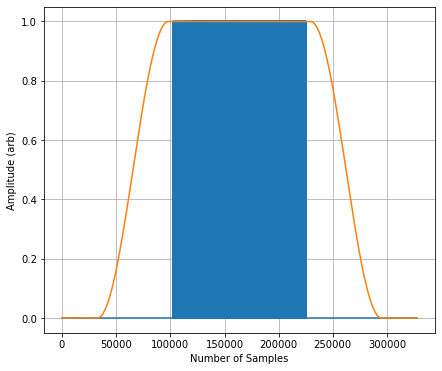

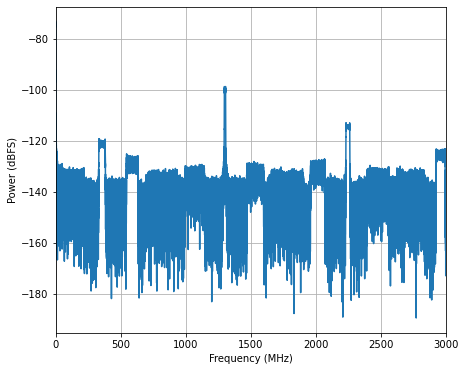

In [9]:
f_ideal, R_ideal, x_data = ideal_chirp.make_ideal_chirp()

In [10]:
if(hdf5_save_en == True):
    # Save ideal data dataframe and cast to np.int16 
    df_ideal_data = pd.DataFrame(x_data).astype(np.int16)

    # Save ideal data dataframe to the hdf5 file
    hdf5_save.save_df_to_hdf5(df_in = df_ideal_data, hdf5_datafile = hdf5_datafile, title = "Ideal_Chirp_Data")

In [11]:
df = pd.read_csv("tx_bram.txt")

# After this scp tx_bram.txt to the zcu102/adrv9009 OS
Run load_tx_bram.c from SDK.

#### Now put "tx_bram.txt" and "put.sh" into  /home/root on the zcu102

<img src="scp.png" alt="Drawing" style="width: 600px;">

#### Load the tx_bram.txt file into the tx_bram memory

<img src="load_txbram.png" alt="Drawing" style="width: 800px;">

### Configure the ADRV9009 Receiver

This class sets the params in the ADRV9009 receiver.  The rx bandwidth of the ADRV9009 defaults to 245.76 MHz, so make sure that the LO frequency is set near the chirp center frequency in the ideal chirp.  Here I have set them to 700 MHz.

ip is: ip:192.168.1.21, LO frequency of the receiver is 700 MHz, RX gain is 25dB, Rx Buffer Size is the number of samples to collect: 32768, TX Gain is not relevent now: -14dB, Calibration not enabled here.

In [13]:
adrv9009_config = txvr.ADRV9009_Config(ip = "ip:192.168.1.21", f_lo = F_LO, rx_gain = 25, rx_buffer_size = RX_N_sample,
                 tx_gain = -14, calibrate_rx_phase_correction_en = 0, calibrate_rx_qec_en = 0, calibrate_tx_qec_en = 0, 
                 calibrate = 1)

In [14]:
df_adrv9009_config_params = hdf5_save.make_df_from_object_params(adrv9009_config)
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_adrv9009_config_params, hdf5_datafile = hdf5_datafile, title = "ADRV9009_Data_Collection_params")

Let's see the config params that were saved.

In [15]:
df_adrv9009_config_params.head()

,rx_buffer_size,ip,frequency_hopping_mode,frequency_hopping_mode_en,calibrate_rx_phase_correction_en,calibrate_rx_qec_en,calibrate_tx_qec_en,calibrate,gain_control_mode_chan0,gain_control_mode_chan1,rx_hardwaregain_chan0,rx_hardwaregain_chan1,tx_hardwaregain_chan0,tx_hardwaregain_chan1,rx_rf_bandwidth,tx_rf_bandwidth,rx_sample_rate,tx_sample_rate,trx_lo
0,102400,b'ip:192.168.1.21',1280000000,0,0,0,0,1,b'manual',b'manual',25,30,-14,-10,200000000,225000000,245760000,245760000,1300000000


Pull data - list size of rx_buffer_size

### Get ADC Data

In [16]:
data = adrv9009_config.get_ADC_data_Read()

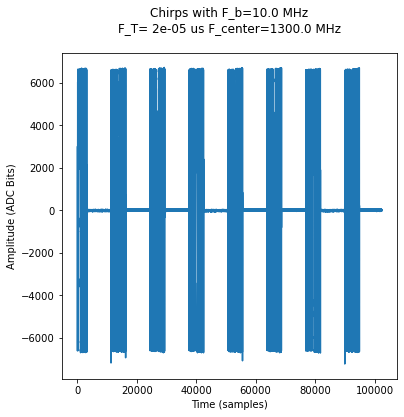

In [17]:
plt.figure(figsize = (6,6))
plt.plot(np.real(data))
plt.ylabel("Amplitude (ADC Bits)")
plt.xlabel("Time (samples)")
plt.title("Chirps with F_b=" + str(B_chirp/1e6) + " MHz\nF_T= " + str(T_chirp) + " us F_center=" + str(F_center/1e6) + " MHz\n")
plt.show()

### Configure Chirp Triggering

Make sure these params match the ideal waveform/adrv9009 receiver or the triggering routine (get_onechirp()) won't work.  

In [18]:
chirp_trigger = txvr.Trigger_ChirpData(F_sample = RX_sample_rate, F_center = F_center, B_chirp = B_chirp, T_chirp = T_chirp, F_LO = F_LO)

Test chirp_trigger against data.  If you encounter an error saying that the script is unable to access an array, the issue is that the 'triggered chirp' is too close to the edge of the end of the collected.  Just re-collect data and the get_onechirp() routine will trigger another chirp.

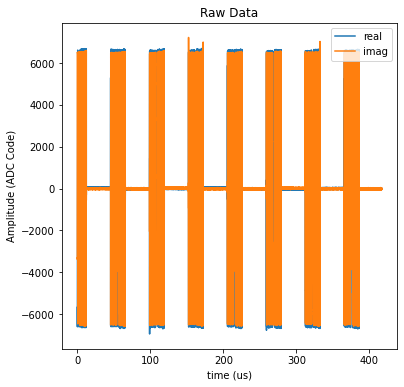

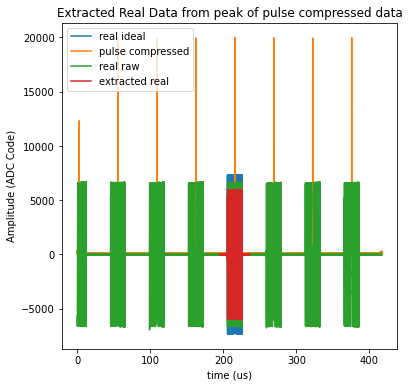

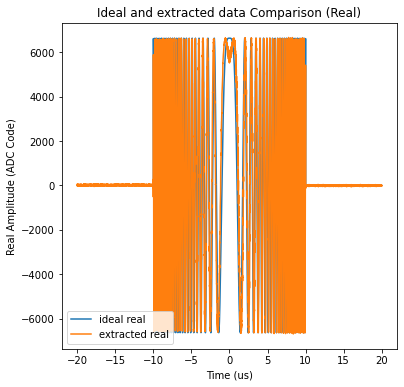

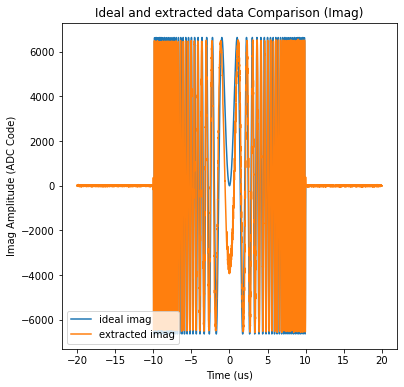

In [37]:
data = adrv9009_config.get_ADC_data_Read()
z_real, z_imag, xf, R_out = chirp_trigger.get_onechirp(np.real(data), np.imag(data), True)

### Collect 200 chirps and parse such that they are time aligned

In [20]:
###############################################################################
# Uses the the ADRV9009_Config() and the Trigger_ChirpData() classes together to pull
# N amount of time series data from the ADRV9009 Receiver.  Output is data_list - list 
# of lists where each list represents a N_samples of data.  Input is N- the length of the
# amount of data samples to pull, adrv9009_config/chirp_trigger - the vars corresponding to the 
# instantiated ADRV9009_Config()/Trigger_ChirpData().
###############################################################################
def get_N_TriggeredData(N = 10, adrv9009_config = None, chirp_trigger = None, verbose = False):
    data_triggered = []
    data_raw = []
    failed = 0
    
    if(adrv9009_config == None or chirp_trigger == None):
        printf("adrv9009_config or chirp_trigger invalid")

    # Uses a try block because there are instances in which get_onechirp does not succeed in obtaining 
    # N_sample = int(2*T_chirp*F_sample)
    # since the chirp packet might be very near the end of the time series data.  In those instances,
    # I just print failed and try to pull data again.
    while(len(data_triggered) < N):
        
        if(failed > 100):
            print("Failed Threshold Exceeded.  Exiting Now.")
            return -1
        
        try:
            data = adrv9009_config.get_ADC_data_Read()
            z_real, z_imag, xf, R_out = chirp_trigger.get_onechirp(np.real(data), np.imag(data), verbose)
            data_triggered.append(z_real + 1j*z_imag)
            data_raw.append(data)
        except: 
            failed+=1
    
    print("Boundary Problem encountered ", failed, " times")

    # list of lists with shape 100 x T_chirp*2 in units of samples.  
    # So, I cast data_list to a pandas dataframe and transpose to get the proper form.
    df_trigger = pd.DataFrame(data_triggered).T
    df_data_raw = pd.DataFrame(data_raw).T
        
    return df_trigger, df_data_raw

Set the number of chirps to collect to 100, feed in the adrv9009_config class which has to do with configuring the receiver, feed in the chirp_trigger class which has the routine to time-align subsequent chirps, set verbose to false.

In [21]:
df_data_extracted, df_data_raw = get_N_TriggeredData(N = 200, adrv9009_config = adrv9009_config, chirp_trigger = chirp_trigger, verbose = False)

Boundary Problem encountered  0  times


In [22]:
df_data_extracted.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,4.000000+36.000000j,-16.000000-30.000000j,-10.000000+2.000000j,-24.000000+11.000000j,-44.000000+15.000000j,8.000000+51.000000j,20.000000+27.000000j,25.000000+44.000000j,-2.000000-18.000000j,-12.000000+11.000000j,...,-1.000000+27.000000j,2.000000+17.000000j,18.000000+41.000000j,24.000000-20.000000j,-41.000000-7.000000j,-31.000000-14.000000j,-25.000000-25.000000j,2.000000-3.000000j,-37.000000-3.000000j,-29.000000-12.000000j
1,-1.000000-17.000000j,18.000000+25.000000j,-1.000000+3.000000j,-9.000000+26.000000j,0.000000-16.000000j,8.000000-18.000000j,23.000000-9.000000j,1.000000-9.000000j,3.000000+1.000000j,25.000000+11.000000j,...,0.000000+3.000000j,-5.000000-21.000000j,15.000000-17.000000j,-3.000000+10.000000j,2.000000-7.000000j,-2.000000-5.000000j,-11.000000+13.000000j,-20.000000-24.000000j,-24.000000-7.000000j,31.000000-3.000000j
2,43.000000+7.000000j,-36.000000+8.000000j,-57.000000-7.000000j,-37.000000+5.000000j,24.000000+0.000000j,28.000000+14.000000j,20.000000+5.000000j,28.000000+43.000000j,0.000000+11.000000j,26.000000+33.000000j,...,39.000000+13.000000j,2.000000+41.000000j,36.000000+0.000000j,-31.000000-24.000000j,-28.000000+14.000000j,-28.000000-11.000000j,-27.000000-8.000000j,22.000000+5.000000j,-7.000000+17.000000j,-16.000000-12.000000j
3,25.000000+31.000000j,-31.000000-11.000000j,-20.000000-13.000000j,-12.000000+10.000000j,-17.000000+11.000000j,21.000000+25.000000j,-5.000000+20.000000j,-9.000000+28.000000j,-36.000000-7.000000j,-22.000000+29.000000j,...,10.000000+33.000000j,3.000000+23.000000j,10.000000+39.000000j,37.000000+2.000000j,-41.000000+2.000000j,-22.000000-14.000000j,-9.000000-29.000000j,5.000000-1.000000j,-69.000000+4.000000j,-23.000000-11.000000j
4,20.000000-21.000000j,11.000000+11.000000j,-33.000000-7.000000j,13.000000+10.000000j,5.000000-9.000000j,-24.000000+3.000000j,4.000000+2.000000j,17.000000-1.000000j,33.000000-16.000000j,28.000000-7.000000j,...,9.000000+11.000000j,25.000000-12.000000j,29.000000-23.000000j,-33.000000+2.000000j,-3.000000+12.000000j,1.000000-4.000000j,5.000000+30.000000j,5.000000-16.000000j,-4.000000+10.000000j,-22.000000+8.000000j


### Incoherent averaging

saves the raw data an array of 16 bit real and imag elems rather than using the Complex128 data type to save space

In [23]:
if(hdf5_save_en == True):
    raw_data_array = hdf5_save.complex128_to_complexint(df_in = df_data_raw)
    hdf5_save.save_array_data_to_hdf5(nparray_in = raw_data_array, title = "Raw_Data")

In [24]:
if(hdf5_save_en == True):
    extracted_data_array = hdf5_save.complex128_to_complexint(df_in = df_data_extracted)
    hdf5_save.save_array_data_to_hdf5(nparray_in = extracted_data_array, title = "Triggered_Data")

Get the size of the dataframe

In [25]:
df_data_extracted.shape

(9830, 200)

Get information on the type of data stored in the dataframe

In [26]:
df_data_extracted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830 entries, 0 to 9829
Columns: 200 entries, 0 to 199
dtypes: complex128(200)
memory usage: 30.0 MB


Show the .head() of the dataframe

In [27]:
df_data_extracted.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,4.000000+36.000000j,-16.000000-30.000000j,-10.000000+2.000000j,-24.000000+11.000000j,-44.000000+15.000000j,8.000000+51.000000j,20.000000+27.000000j,25.000000+44.000000j,-2.000000-18.000000j,-12.000000+11.000000j,...,-1.000000+27.000000j,2.000000+17.000000j,18.000000+41.000000j,24.000000-20.000000j,-41.000000-7.000000j,-31.000000-14.000000j,-25.000000-25.000000j,2.000000-3.000000j,-37.000000-3.000000j,-29.000000-12.000000j
1,-1.000000-17.000000j,18.000000+25.000000j,-1.000000+3.000000j,-9.000000+26.000000j,0.000000-16.000000j,8.000000-18.000000j,23.000000-9.000000j,1.000000-9.000000j,3.000000+1.000000j,25.000000+11.000000j,...,0.000000+3.000000j,-5.000000-21.000000j,15.000000-17.000000j,-3.000000+10.000000j,2.000000-7.000000j,-2.000000-5.000000j,-11.000000+13.000000j,-20.000000-24.000000j,-24.000000-7.000000j,31.000000-3.000000j
2,43.000000+7.000000j,-36.000000+8.000000j,-57.000000-7.000000j,-37.000000+5.000000j,24.000000+0.000000j,28.000000+14.000000j,20.000000+5.000000j,28.000000+43.000000j,0.000000+11.000000j,26.000000+33.000000j,...,39.000000+13.000000j,2.000000+41.000000j,36.000000+0.000000j,-31.000000-24.000000j,-28.000000+14.000000j,-28.000000-11.000000j,-27.000000-8.000000j,22.000000+5.000000j,-7.000000+17.000000j,-16.000000-12.000000j
3,25.000000+31.000000j,-31.000000-11.000000j,-20.000000-13.000000j,-12.000000+10.000000j,-17.000000+11.000000j,21.000000+25.000000j,-5.000000+20.000000j,-9.000000+28.000000j,-36.000000-7.000000j,-22.000000+29.000000j,...,10.000000+33.000000j,3.000000+23.000000j,10.000000+39.000000j,37.000000+2.000000j,-41.000000+2.000000j,-22.000000-14.000000j,-9.000000-29.000000j,5.000000-1.000000j,-69.000000+4.000000j,-23.000000-11.000000j
4,20.000000-21.000000j,11.000000+11.000000j,-33.000000-7.000000j,13.000000+10.000000j,5.000000-9.000000j,-24.000000+3.000000j,4.000000+2.000000j,17.000000-1.000000j,33.000000-16.000000j,28.000000-7.000000j,...,9.000000+11.000000j,25.000000-12.000000j,29.000000-23.000000j,-33.000000+2.000000j,-3.000000+12.000000j,1.000000-4.000000j,5.000000+30.000000j,5.000000-16.000000j,-4.000000+10.000000j,-22.000000+8.000000j


Display the first column in the dataframe

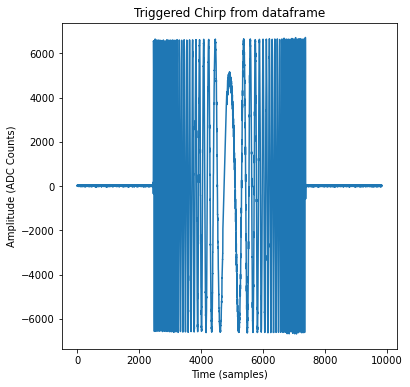

In [28]:
plt.figure(figsize = (6,6))
plt.plot(np.real(df_data_extracted[0]))
plt.ylabel("Amplitude (ADC Counts)")
plt.xlabel("Time (samples)")
plt.title("Triggered Chirp from dataframe")
plt.show()

The sample rate is set to receiver sample rate, F_center is the center frequency of the chirp, B_chirp is the bandwidth of the chirp, T_chirp is the duration and F_LO is the LO frequency of the receiver.

In [29]:
chirp_avg = txvr.Chirp_average(F_sample = RX_sample_rate, F_center = F_center, B_chirp = B_chirp, T_chirp = T_chirp, F_LO = F_LO)

C:\software\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


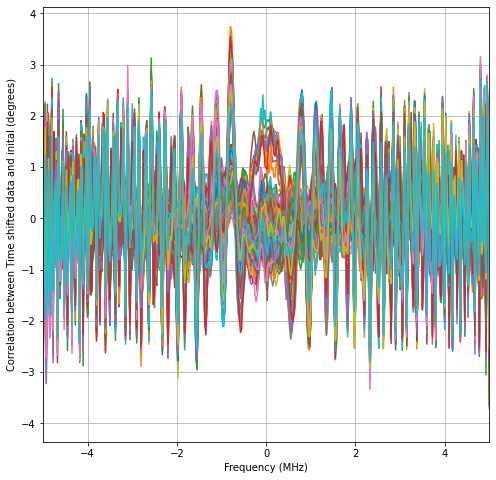

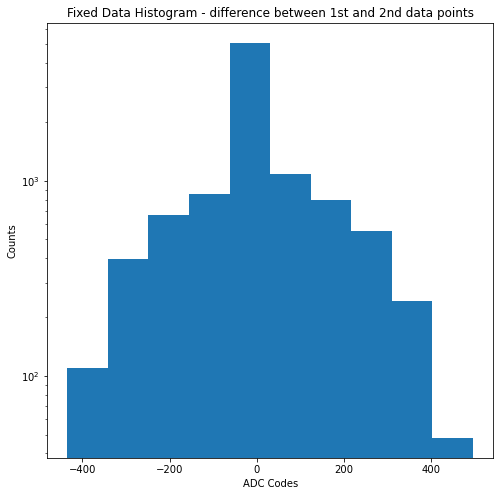

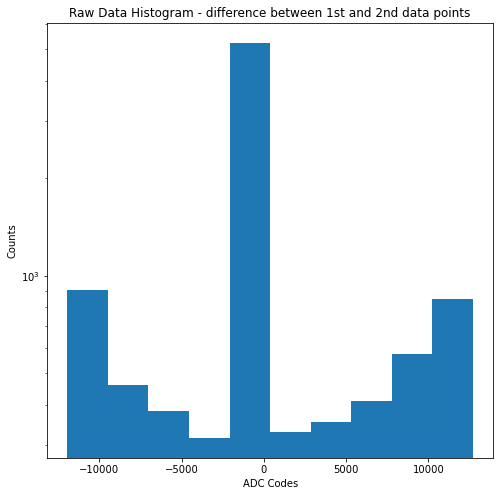

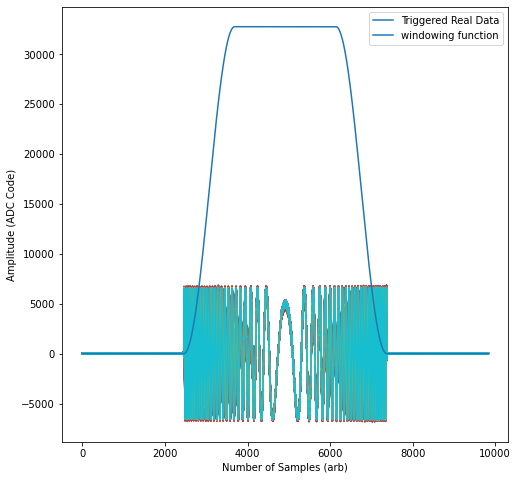

In [30]:
f, R, df_Xfix = chirp_avg.get_chirp_averages(df = df_data_extracted, N_avg = 100, verbose= True)

In [31]:
if(hdf5_save_en == True):
    fixed_data_array = hdf5_save.complex128_to_complexint(df_in = df_Xfix)
    hdf5_save.save_array_data_to_hdf5(nparray_in = fixed_data_array, title = "Fixed_Data")

### Plot the averaged data from the ADRV9009

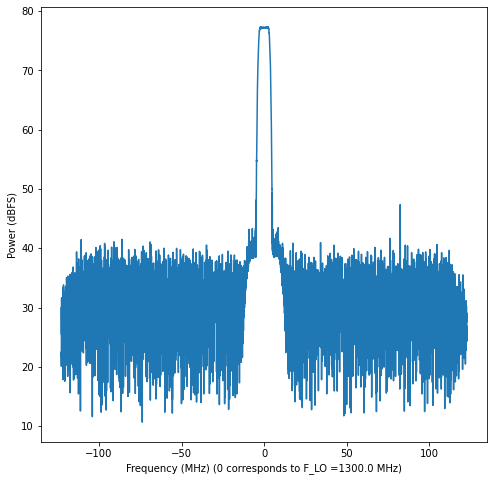

In [32]:
plt.figure(figsize = (8,8))
plt.plot(f, R)
plt.xlabel("Frequency (MHz) (0 corresponds to F_LO =" + str(F_LO/1e6) + " MHz)")
plt.ylabel("Power (dBFS)")
plt.show()

### Plot averaged data from ADRV9009 and ideal data

Get bounds so that frequency plot matches

In [33]:
F_sample = chirp_avg.F_sample/1e6
F_center = chirp_avg.F_center/1e6
f_min = F_center - F_sample/2
f_max = F_center + F_sample/2

Slice the ideal data such that I'm within the ADRV9009 Receiver Bandwidth.  Subtract 700 from frequency to plot on Receiver axis (0 Mhz corresponds to LO frequency of 700 MHz).

In [34]:
f_ideal_mod = f_ideal[(np.abs(f_ideal - f_min)).argmin():(np.abs(f_ideal - f_max)).argmin()] - F_LO/1e6
R_ideal_mod = R_ideal[(np.abs(f_ideal - f_min)).argmin():(np.abs(f_ideal - f_max)).argmin()]

Add an offset so I can compare the SNR of the two plots

In [35]:
offset = 176

Plot the data

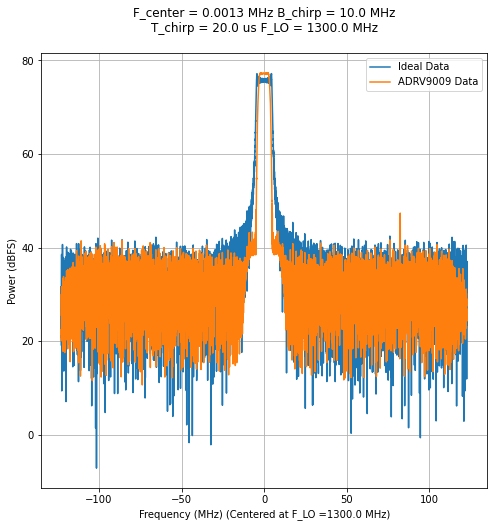

In [36]:
plt.figure(figsize = (8,8))
plt.plot(f_ideal_mod, 10*np.log(R_ideal_mod)/np.log(10)+offset, label="Ideal Data")
plt.plot(f, R, label="ADRV9009 Data")
plt.legend()
plt.title("F_center = " + str(F_center/1e6) + " MHz " + "B_chirp = " + str(B_chirp/1e6) + " MHz\n" +
          "T_chirp = " + str(T_chirp*1e6) + " us" + " F_LO = " + str(F_LO/1e6) + " MHz\n")
plt.xlabel("Frequency (MHz) (Centered at F_LO =" + str(F_LO/1e6) + " MHz)")
plt.ylabel("Power (dBFS)")
plt.savefig("F_LO =" + str(F_LO/1e6) + " MHz.pdf")
plt.grid()
plt.show()